In [3]:
import numpy as np
import polars as pl
import yaml
import matplotlib.pyplot as plt

from scipy.stats import t

# Use the same HV implementation in moocore
import moocore

In [40]:
data_path = "./results/data/g8_baseline_gen150_runs500_cthigh_psize12.parquet"
front_path = "./results/fronts/g8_gen10000_psize200.parquet"
thresholds_path = "./results/thresholds/branin.yaml"

objective_symbol = "f_1"
constraint_symbols = ["c_1", "c_2"]
ct_level = "med"  # "low" | "med" | "high"

f_col = f"{objective_symbol}_min"
c_cols = constraint_symbols
dim_cols = [f_col] + c_cols

In [41]:
df = pl.read_parquet(data_path)
df_front = pl.read_parquet(front_path)

df.select(["run", "generation"] + dim_cols).head()

run,generation,f_1_min,c_1,c_2
i32,i32,f64,f64,f64
0,1,0.000386,19.118297,18.86061
0,1,0.001007,1.767569,2.731595
0,1,-0.000017,64.122294,-6.213802
0,1,-0.000871,0.96931,-0.62721
0,1,-0.000003,75.95722,1.703727


In [42]:
with open(thresholds_path, encoding="utf-8") as f:
    thresholds_doc = yaml.safe_load(f)

level_constraints = dict(thresholds_doc["levels"].get(ct_level, {}))
constraints = {c: float(level_constraints.get(c, 0.0)) for c in c_cols}

terms = []
for c in c_cols:
    th = constraints[c]
    terms.append(pl.col(c) <= (th if th > 0.0 else 0.0))
ref_filter = pl.all_horizontal(terms)

reference_front = df_front.filter(ref_filter)
if reference_front.height == 0:
    raise ValueError(f"Reference front empty after filtering by {ct_level}: {constraints}")

reference_front.select(dim_cols).describe()

statistic,f_1_min,c_1,c_2
str,f64,f64,f64
"""count""",31334.0,31334.0,31334.0
"""null_count""",0.0,0.0,0.0
"""mean""",-0.003597,6.361995,-1.941
"""std""",0.013577,4.530405,0.809899
"""min""",-0.095795,-2.119837,-3.264247
"""25%""",-0.002125,3.585567,-2.634475
"""50%""",-0.00048,6.21063,-2.023781
"""75%""",5.9741e-8,10.355431,-1.544358
"""max""",0.029265,15.155405,-0.00003


In [43]:
ref = np.array(
    [reference_front[f_col].max()] + [reference_front[c].max() for c in c_cols],
    dtype=float,
)

ref

array([ 2.92654284e-02,  1.51554047e+01, -3.03041453e-05])

In [44]:
hv_ind = moocore.Hypervolume(ref=ref, maximise=False)


def filter_to_ref_box(arr: np.ndarray, ref: np.ndarray) -> np.ndarray:
    if arr.size == 0:
        return arr
    return arr[(arr <= ref).all(axis=1)]


rows = []
for (run, gen), sub in df.group_by(["run", "generation"], maintain_order=True):
    pts = sub.select(dim_cols).to_numpy()

    # discard points that cannot contribute (outside ref box)
    pts = filter_to_ref_box(pts, ref)

    hv_val = None if pts.shape[0] == 0 else float(hv_ind(pts))
    rows.append((int(run), int(gen), hv_val, pts.shape[0]))

hv_df = pl.DataFrame(rows, schema=["run", "generation", "hv", "n_points_used"]).sort(["run", "generation"])
hv_df.head()

/tmp/ipykernel_1959158/3290349059.py:20: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  hv_df = pl.DataFrame(rows, schema=["run", "generation", "hv", "n_points_used"]).sort(["run", "generation"])


run,generation,hv,n_points_used
i64,i64,f64,i64
0,1,0.294903,4
0,2,0.353665,2
0,3,0.258543,1
0,4,0.206206,2
0,5,0.621413,5


In [45]:
hv_summary = (
    hv_df.group_by("generation")
    .agg(
        pl.col("hv").mean().alias("hv_mean"),
        pl.col("hv").std().alias("hv_std"),
        pl.col("hv").count().alias("n_runs_support"),
    )
    .with_columns(
        pl.when(pl.col("n_runs_support") > 1)
        .then(pl.col("hv_std") / pl.col("n_runs_support").sqrt())
        .otherwise(None)
        .alias("hv_stderr"),
    )
    .sort("generation")
)

# t critical for 95% CI
gens = hv_summary["generation"].to_list()
n = hv_summary["n_runs_support"].to_list()

tcrit = [float(t.ppf(0.975, ni - 1)) if ni and ni > 1 else None for ni in n]
hv_summary = hv_summary.with_columns(pl.Series("t_crit", tcrit))

hv_summary = hv_summary.with_columns(
    (pl.col("hv_mean") + pl.col("t_crit") * pl.col("hv_stderr")).alias("hv_ci_upper"),
    (pl.col("hv_mean") - pl.col("t_crit") * pl.col("hv_stderr")).alias("hv_ci_lower"),
)

hv_summary.head()

generation,hv_mean,hv_std,n_runs_support,hv_stderr,t_crit,hv_ci_upper,hv_ci_lower
i64,f64,f64,u32,f64,f64,f64,f64
1,0.294903,0.0,500,0.0,1.964729,0.294903,0.294903
2,0.201912,0.149346,152,0.012114,1.975799,0.225846,0.177978
3,0.278667,0.154022,260,0.009552,1.969166,0.297477,0.259858
4,0.337595,0.176138,258,0.010966,1.969237,0.35919,0.316001
5,0.371299,0.187682,296,0.010909,1.968038,0.392768,0.34983


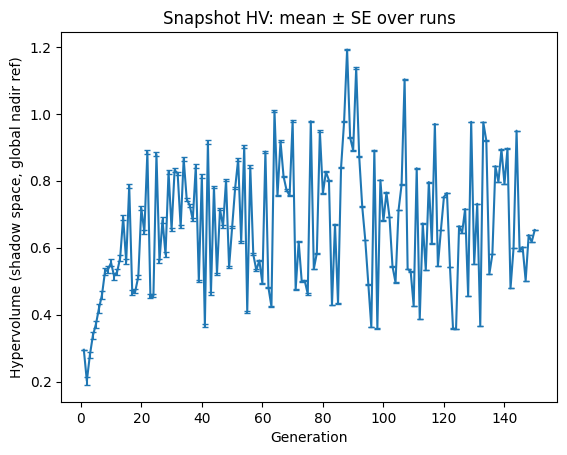

In [46]:
g = hv_summary["generation"].to_numpy()
m = hv_summary["hv_mean"].to_numpy()
se = hv_summary["hv_stderr"].to_numpy()

plt.figure()
plt.plot(g, m)
plt.errorbar(g, m, yerr=se, fmt="none", capsize=2)  # stderr bars
plt.xlabel("Generation")
plt.ylabel("Hypervolume (shadow space, global nadir ref)")
plt.title("Snapshot HV: mean ± SE over runs")
plt.show()